In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [1]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [3]:
!wget $data -O course_lead_scoring.csv 

--2025-10-15 19:36:57--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.01s   

2025-10-15 19:36:57 (7.68 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [4]:
df = pd.read_csv('course_lead_scoring.csv')

In [18]:
print(df.isnull().sum())

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [10]:
strings = list(df.dtypes[df.dtypes == 'object'].index)
strings

['lead_source', 'industry', 'employment_status', 'location']

In [23]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score', 'converted']

In [24]:
for cat in categorical: 
    df[cat] = df[cat].fillna('NA')

for num in numerical: 
    df[num] = df[num].fillna(0)

In [16]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [20]:
from sklearn.metrics import roc_auc_score

In [22]:
target_features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

for feature in target_features:
    feature_values = df_train[feature]

    auc = roc_auc_score(y_train, feature_values)

    print(f"{feature}: AUC = {auc:.4f}")

lead_score: AUC = 0.6145
number_of_courses_viewed: AUC = 0.7636
interaction_count: AUC = 0.7383
annual_income: AUC = 0.5520


In [28]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

features = categorical + [col for col in numerical if col != 'converted']

train_dict = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [35]:
X_train

array([[9.5543e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        2.0000e+00],
       [5.4924e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        1.0000e+00],
       [7.7352e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        2.0000e+00],
       ...,
       [7.3702e+04, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        1.0000e+00],
       [9.3341e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]], shape=(876, 31))

In [33]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [34]:
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_val_pred_proba )
auc

0.8171316268814112

Intersection at threshold: 0.640
Maximum F1 score: 0.8125
Optimal F1 threshold: 0.570


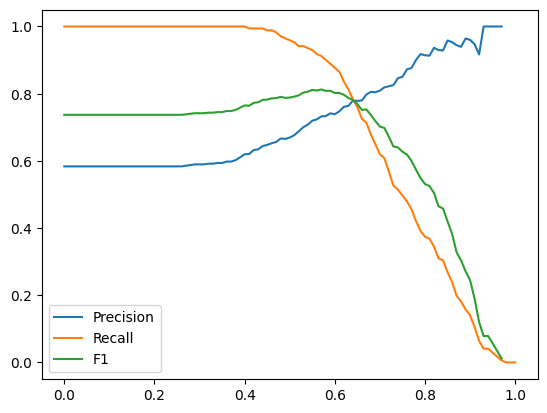

In [44]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_val_pred_proba >= t)
    predict_negative = (y_val_pred_proba < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

# Calculate precision and recall
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

df_scores['f1'] = 2 * df_scores['precision'] * df_scores['recall'] / (df_scores['precision'] + df_scores['recall'])

# Plot precision and recall
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.plot(df_scores.threshold, df_scores['f1'], label='F1')
plt.legend()

# Find intersection
diff = abs(df_scores['precision'] - df_scores['recall'])
intersection_idx = diff.idxmin()
intersection_threshold = df_scores.loc[intersection_idx, 'threshold']
print(f"Intersection at threshold: {intersection_threshold:.3f}")

# Find optimal F1
max_f1_idx = df_scores['f1'].idxmax()
optimal_f1_threshold = df_scores.loc[max_f1_idx, 'threshold']
max_f1_value = df_scores['f1'].max()
print(f"Maximum F1 score: {max_f1_value:.4f}")
print(f"Optimal F1 threshold: {optimal_f1_threshold:.3f}")


In [46]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [47]:
!pip install tqdm

In [48]:
def train(df_train, y_train, C=1.0):
    # Remove target column and convert to dict
    train_dict = df_train.drop('converted', axis=1).to_dict(orient='records')
    
    # DictVectorizer
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    
    # Train model
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df_val, dv, model):
    # Convert to dict and transform
    val_dict = df_val.drop('converted', axis=1).to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    # Return probabilities
    return model.predict_proba(X_val)[:, 1]

In [51]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    # Your preprocessing and training code here
    # (DictVectorizer + LogisticRegression with C=1.0)
    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=1.0 %.3f +- %.3f' % (np.mean(scores), np.std(scores)))
print(f"Standard deviation: {np.std(scores):.6f}")

C=1.0 0.822 +- 0.036
Standard deviation: 0.035807


In [52]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

# Test only the 3 C values specified in Question 6
for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values  # Changed from 'churn'
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print('C=%s %.3f +- %.3f' % (C, mean_score, std_score))

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036
